<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/%5B0731new%5D_machine_learning_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. CNN_LSTM (20개 과거 → 5개 미래)

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 데이터 생성
# 1. 데이터 생성
np.random.seed(42)
days = 30
points_per_day = 24 * 12
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

scaler = MinMaxScaler()
cpu_scaled =pd.DataFrame( scaler.fit_transform(df[['cpu']]))

# 정규화는 train만 fit
split_point = int(len(cpu_scaled) * 0.8)
df_train = cpu_scaled.iloc[:split_point]
df_test = cpu_scaled.iloc[split_point:]


# 시퀀스 생성
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5

# train/test 시퀀스 구성
X_train, y_train = create_sequences(df_train, past_steps, future_steps)

# test는 train 끝 20개와 test 앞부분을 붙여 sliding (test에 train 안들어가게)
# test_base = np.concatenate([cpu_train_scaled[-past_steps:], cpu_test_scaled])
# X_test, y_test = create_sequences(test_base, past_steps, future_steps)
X_test, y_test = create_sequences(df_test, past_steps, future_steps)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), epochs=50, batch_size=16, verbose=1)

pred = model.predict(X_test).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0353
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.2254e-04
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.2585e-04
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 2.9935e-04
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.8961e-04
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.8579e-04
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 2.6102e-04
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.6643e-04
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.7766e-04
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.6692e-04
Epoch 11/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.5157e-04
Epoch 12/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.6034e-04
Epoch 13/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.6121e-04
Epoch 14/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.6073e-04
Epoch 15/50
431/

CNN-LSTM
MAE : 0.5600792005102793
RMSE: 0.7019715176596864
R²  : 0.9892613892115598


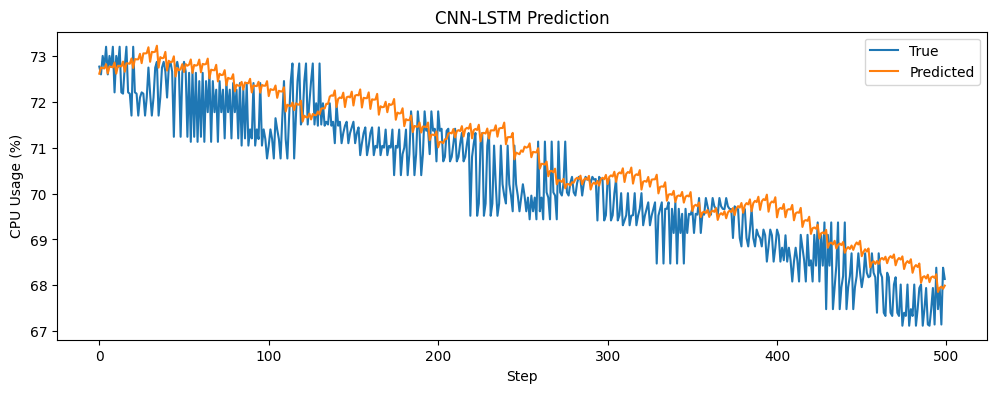

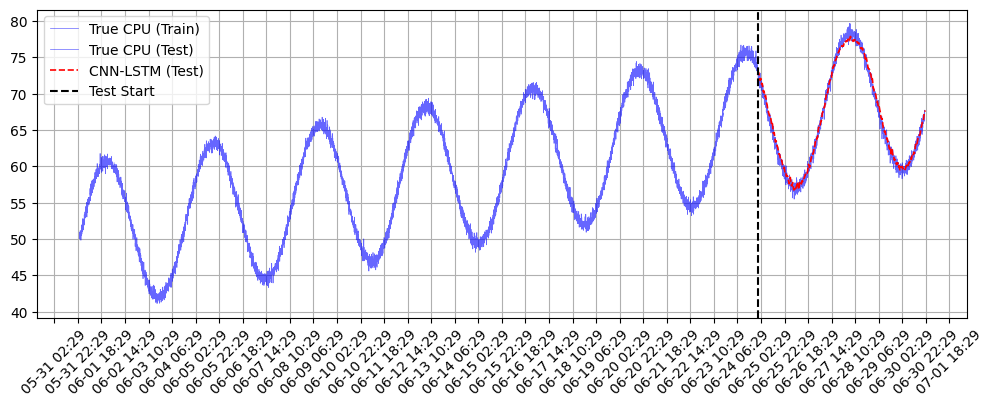

In [33]:
# plot

print("CNN-LSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN-LSTM Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
full_time_index = df.index  # 전체 시간 index (x축)
test_start_idx = len(X_train) + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지

test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200)) # 20시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

## 2. 단순 CNN

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# np.random.seed(42)
# days = 30
# points_per_day = 24 * 12  # 5분 간격
# total_points = days * points_per_day

# time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
# cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
# df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

# scaler = MinMaxScaler()
# cpu_scaled =pd.DataFrame( scaler.fit_transform(df[['cpu']]))

# # 정규화는 train만 fit
# split_point = int(len(cpu_scaled) * 0.8)
# df_train = cpu_scaled.iloc[:split_point]
# df_test = cpu_scaled.iloc[split_point:]


# 시퀀스 생성
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5

# train/test 시퀀스 구성
X_train, y_train = create_sequences(df_train, past_steps, future_steps)

# test는 train 마지막 20개와 test 앞부분을 이어붙여 구성
# test_base = np.concatenate([cpu_train_scaled[-past_steps:], cpu_test_scaled])
# X_test, y_test = create_sequences(test_base, past_steps, future_steps)
X_test, y_test = create_sequences(df_test, past_steps, future_steps)

# CNN-only 모델
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

# reshape for Conv1D
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model.fit(X_train_cnn, y_train, epochs=20, batch_size=16, verbose=1)
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)

pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0183
Epoch 2/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3728e-04
Epoch 3/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2120e-04
Epoch 4/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8663e-04
Epoch 5/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7621e-04
Epoch 6/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7079e-04
Epoch 7/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5752e-04
Epoch 8/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5329e-04
Epoch 9/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5420e-04
Epoch 10/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6562e-04
Epoch 11/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4246e-04
Epoch 12/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4860e-04
Epoch 13/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.4468e-04
Epoch 14/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4205e-04
Epoch 15/20
431/

CNN
MAE : 0.530452758231582
RMSE: 0.6644753371208622
R²  : 0.9903779431306562


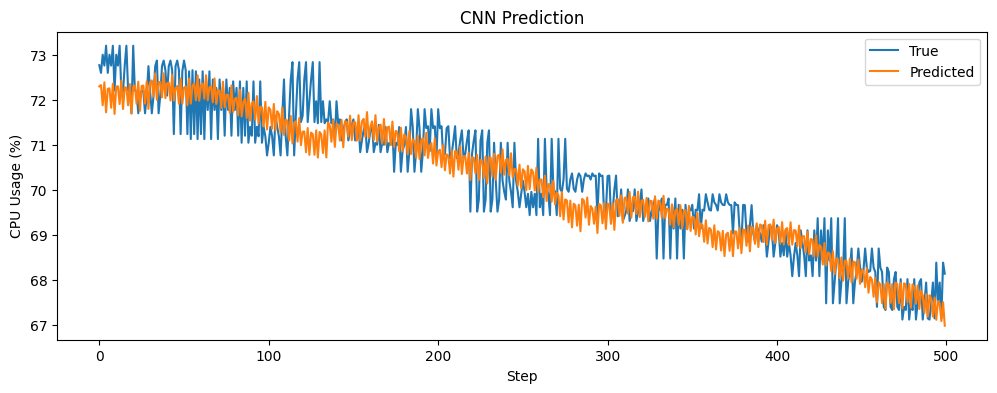

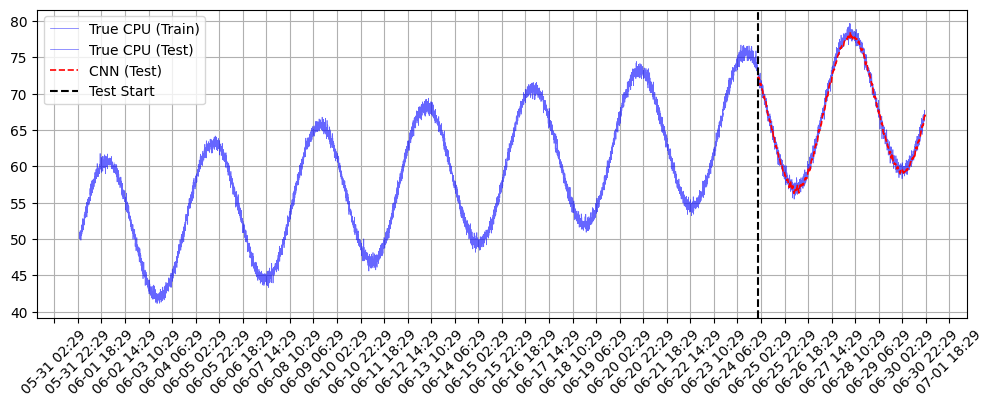

In [10]:
# plot

print("CNN")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
full_time_index = df.index  # 전체 시간 index (x축)
test_start_idx = len(X_train) + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지

test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200)) # 20시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

## 3. CNN-LSTM + Autoregressive , (20개 과거 → 1개 미래)를 반복해 하나씩 예측

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# 1. 데이터 생성
np.random.seed(42)
days = 30
points_per_day = 24 * 12  # 5분 간격
total_points = days * points_per_day
time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + \
      np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

# 2. 정규화
scaler = MinMaxScaler()
cpu_scaled = pd.DataFrame(scaler.fit_transform(df[['cpu']]), index=df.index, columns=['cpu'])

# 3. train/test 분할
split_point = int(len(cpu_scaled) * 0.8)
df_train = cpu_scaled.iloc[:split_point]
df_test = cpu_scaled.iloc[split_point:]

# 4. 시퀀스 생성 함수
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps].values)
        y.append(dataset[i+past_steps:i+past_steps+future_steps].values)
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5

X_train, y_train = create_sequences(df_train, past_steps, future_steps)
X_test, y_test = create_sequences(df_test, past_steps, future_steps)

# 5. CNN-LSTM 모델 정의
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

# 6. 학습 (reshape 필요)
model.fit(X_train.reshape((-1, past_steps, 1)),
          y_train.reshape((y_train.shape[0], -1)),
          epochs=10, batch_size=16, verbose=1)

# 7. Autoregressive 방식으로 예측
test_base = np.concatenate([df_train[-past_steps:], df_test])  # context 추가
preds, truths = [], []

for i in range(0, len(test_base) - past_steps - future_steps):
    input_seq = test_base[i:i+past_steps].values.reshape(1, past_steps, 1)
    pred_seq = []
    for _ in range(future_steps):
        pred = model.predict(input_seq, verbose=0)
        pred_seq.append(pred[0][0])
        input_seq = np.append(input_seq[:, 1:, :], [[[pred[0][0]]]], axis=1)
    preds.append(pred_seq)
    truths.append(test_base[i+past_steps:i+past_steps+future_steps].values.flatten())

preds_inv = scaler.inverse_transform(np.array(preds))
truths_inv = scaler.inverse_transform(np.array(truths))

# 8. 성능 평가
print("CNN-LSTM (Autoregressive)")
print("MAE :", mean_absolute_error(truths_inv, preds_inv))
print("RMSE:", np.sqrt(mean_squared_error(truths_inv, preds_inv)))
print("R²  :", r2_score(truths_inv, preds_inv))

# 9. 시각화: 예측 일부
plt.figure(figsize=(12, 4))
plt.plot(truths_inv[:500].flatten(), label="True")
plt.plot(preds_inv[:500].flatten(), label="Predicted")
plt.title("CNN-LSTM (Autoregressive) Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.grid(True)
plt.show()

# 10. 시각화: 전체 시계열 기반 그래프
test_start_idx = len(X_train) + past_steps
test_time_index = df.index[test_start_idx:test_start_idx + len(truths)]
train_series = df['cpu'][:test_start_idx]
test_series_true = pd.Series(truths_inv.flatten(), index=test_time_index)

# 예측 시계열 생성
all_future_times = []
all_future_preds = []
future_interval = 5

for i in range(len(test_time_index)):
    for j in range(future_steps):
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(preds_inv[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": np.array(all_future_preds)})
pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'].values, index=pred_df_mean.index)

# 시각화
fig, ax = plt.subplots(figsize=(12, 4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth=1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0380
Epoch 2/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.3442e-04
Epoch 3/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.2458e-04
Epoch 4/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 3.1066e-04
Epoch 5/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9646e-04
Epoch 6/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.7966e-04
Epoch 7/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.6901e-04
Epoch 8/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.7161e-04
Epoch 9/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.8235e-04
Epoch 10/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 2.7309e-04


AttributeError: 'numpy.ndarray' object has no attribute 'values'

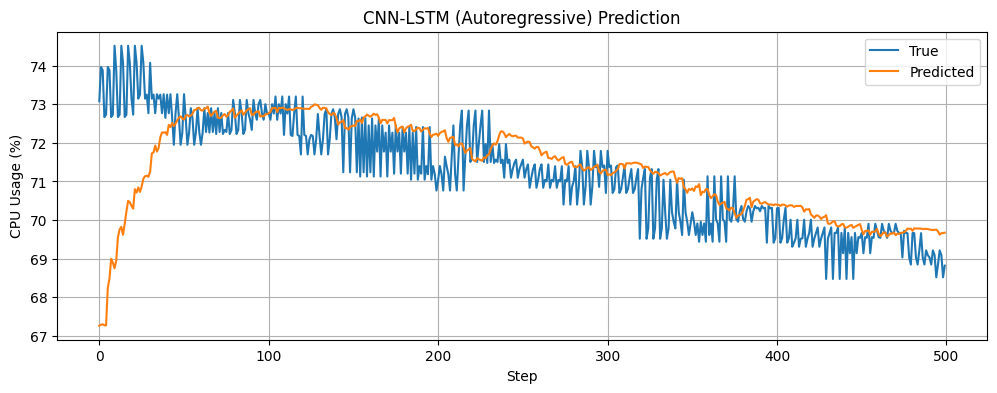

ValueError: Length of values (1723) does not match length of index (1708)

In [44]:
# plot
# Plot 1: 예측 vs 실제
plt.figure(figsize=(12, 4))
plt.plot(truths_inv.flatten()[:500], label="True")
plt.plot(preds_inv.flatten()[:500], label="Predicted")
plt.title("CNN-LSTM (Autoregressive) Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: 전체 시간 시계열 기반
test_start_idx = split_point + past_steps
# 필요한 인덱스 길이는 truths_inv와 동일하게 설정
test_time_index = df.index[test_start_idx : test_start_idx + len(truths_inv)]

# 그에 맞춰 시리즈 생성
test_series_true = pd.Series(truths_inv[:, 0], index=test_time_index)

train_series = df['cpu'][:test_start_idx]

# 예측 시계열 생성
all_future_times = []
all_future_preds = []
future_interval = 5

for i in range(len(test_time_index)):
    for j in range(future_steps):
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(preds[i, j])

pred_df = pd.DataFrame({
    "time": all_future_times,
    "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()
})
pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index)

# 시각화
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Autoregressive)", color="red", linestyle="--", linewidth=1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.legend()
plt.grid(True)
plt.show()

# 성능 출력
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

## 4. FLNN + GA-PSO

In [38]:
# ========== FLNN 정의 ==========
def flnn_predict(w, X):
    return np.dot(X, w[:-1]) + w[-1]

def eval(ind):
    return (np.abs(flnn_predict(np.array(ind), X_train) - y_train).mean(),)

# GA 구성
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=past_steps+1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", eval)

pop = toolbox.population(n=30)
pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=15, verbose=False)
best_ga = tools.selBest(pop, 1)[0]

# PSO
def pso_obj(w):
    return np.array([np.abs(flnn_predict(p, X_train) - y_train).mean() for p in w])

optimizer = ps.single.GlobalBestPSO(
    n_particles=20,
    dimensions=past_steps+1,
    options={'c1':1.5, 'c2':1.5, 'w':0.7},
    init_pos=np.tile(best_ga, (20, 1)) + np.random.normal(0, 0.1, (20, past_steps+1))
)
_, best_pso = optimizer.optimize(pso_obj, iters=100)

# 예측 및 복원
y_pred = flnn_predict(best_pso, X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1))
y_true_inv = scaler.inverse_transform(y_test.reshape(-1,1))

# 평가 출력
print("FLNN-GA-PSO")
print("MAE :", mean_absolute_error(y_true_inv, y_pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(y_true_inv, y_pred_inv)))
print("R²  :", r2_score(y_true_inv, y_pred_inv))

# 시각화 (앞 500개)
plt.figure(figsize=(12, 4))
plt.plot(y_true_inv[:500], label="True")
plt.plot(y_pred_inv[:500], label="Predicted")
plt.title("FLNN-GA-PSO Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


ValueError: shapes (6887,20,1) and (20,) not aligned: 1 (dim 2) != 20 (dim 0)

In [23]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# 전체 시간 인덱스
full_time_index = df.index

# test 시작 위치 계산 (train 끝 + 슬라이딩 past_steps 보정)
test_start_idx = len(df_train) + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

# Train 데이터 실제값 (복원 전 원래 값)
train_series = df['cpu'][:test_start_idx]

# Test 구간 실제값, 예측값 시리즈 생성
test_series_true = pd.Series(y_true_inv, index=test_time_index)
test_series_pred = pd.Series(y_pred_inv, index=test_time_index)

# 시각화
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_pred, label="FLNN-GA-PSO (Predicted)", color="red", linestyle="--", linewidth=1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200))  # 20시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.title("FLNN-GA-PSO Train + Test CPU Prediction")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Data must be 1-dimensional, got ndarray of shape (858, 1) instead

In [31]:
y_train.shape

(6906,)

## 2. CNN-BiLSTM + sliding window (5) + CNN 2층 쌓기

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,949 (261.52 KB)

 Trainable params: 66,949 (261.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0153
Epoch 2/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.0003e-04
Epoch 3/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 4.0601e-04
Epoch 4/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.7590e-04
Epoch 5/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.8263e-04
Epoch 6/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.6662e-04
Epoch 7/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.3312e-04
Epoch 8/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 3.1545e-04
Epoch 9/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.0060e-04
Epoch 10/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.8633e-04
Epoch 11/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 2.6425e-04
Epoch 12/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 2.9059e-04
Epoch 13/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.5703e-04
Epoch 14/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.55

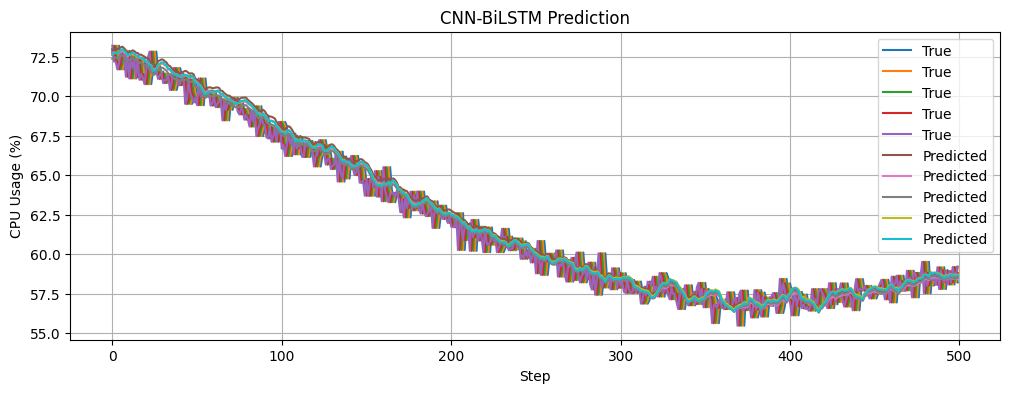

In [34]:
# reshape y to match CNN-BiLSTM output
y_train_re = y_train.reshape(-1, future_steps)
y_test_re  = y_test.reshape(-1, future_steps)

# ✅ CNN-BiLSTM 모델 구성
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, activation='tanh')),
    Dense(future_steps)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ✅ reshape for Conv1D & LSTM
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ✅ 학습
model.fit(X_train_cnn, y_train_re, epochs=20, batch_size=16, verbose=1)

# ✅ 예측
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test_re.reshape(-1, future_steps)

# ✅ 복원 (정규화 → 원래 단위 [%]로)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)

# ✅ 성능 출력
print("CNN-BiLSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


CNN
MAE : 0.5069721441335628
RMSE: 0.6392430793249102
R²  : 0.9910956102478318


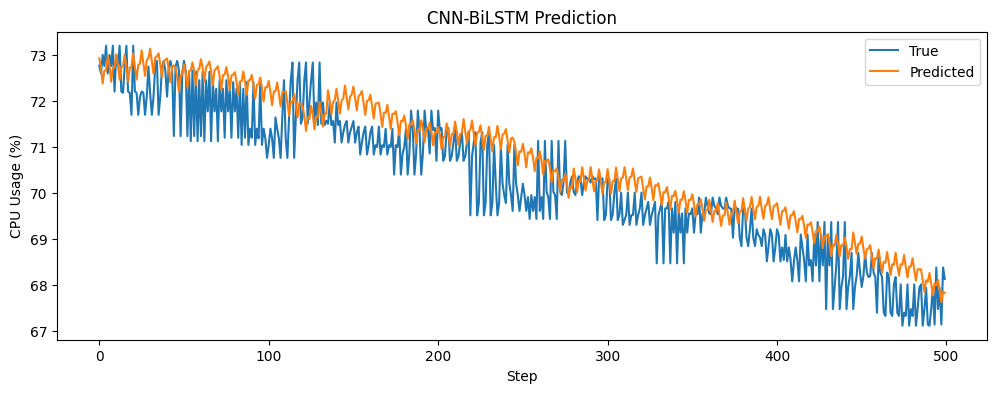

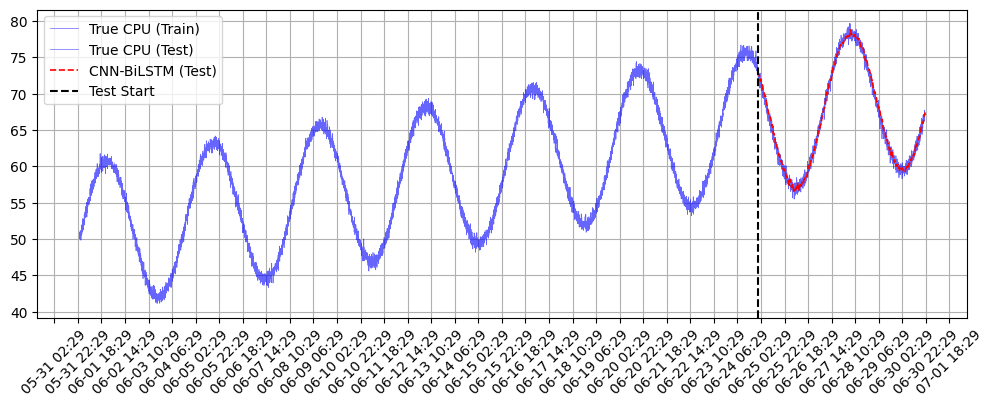

In [37]:
# plot

print("CNN")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN-BiLSTM Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
full_time_index = df.index  # 전체 시간 index (x축)
test_start_idx = len(X_train) + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지

test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-BiLSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200)) # 20시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()